#### Bessel function based optimization

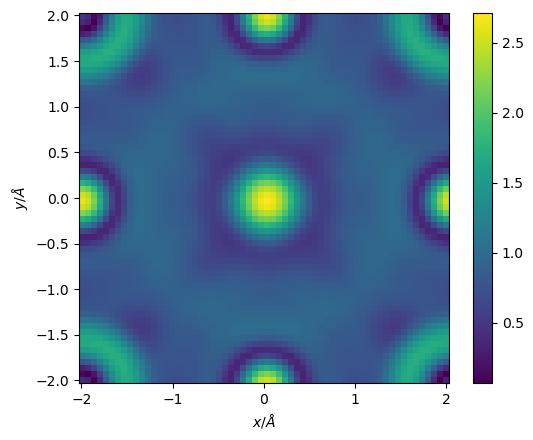

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from ase import Atoms
import sys
sys.path.append("../Functions")
from structure_generator import (
    construction_periodic,
    set_dopants,
    construct_amorphous)
from GS_waves import select_freq_range
from abtem.waves import PlaneWave

#Construct periodic structure
a = 2.0247 * 2
Al = Atoms("Al4", cell=[a, a, a], pbc=(1, 1, 1), 
           scaled_positions=[(0, 0, 0), (0, 0.5, 0.5), (0.5, 0, 0.5), (0.5, 0.5, 0)])
energy = 300e3; sampling = 0.0656015; gmin = 0; gmax=1.5
structure = construction_periodic(Al, 1, 1, 20)

#Constants irrelevant to thickness
#n = 20; A = a; h = a; gap = 0.0128; H = h*(n-1)
#Results from pure Aluminum column
ew = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure).array),
                           gmin, gmax, sampling)
plt.imshow(np.abs(ew), extent=[-a/2, a/2, -a/2, a/2])
plt.xlabel(r"$x/\AA$")
plt.ylabel(r"$y/\AA$")
plt.colorbar()
plt.show()

/var/folders/06/8n008hdd2ls9jb4qk47sydy00000gn/T/ipykernel_6967/1290201971.py:17: RuntimeWarning: invalid value encountered in divide
  results = np.array(results)/np.sqrt(krange)


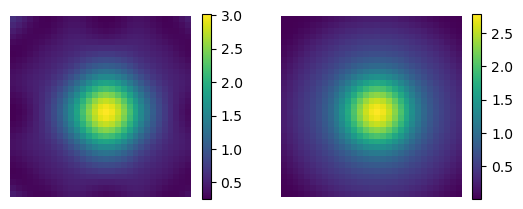

In [2]:
from scipy.special import j0
def Bessel_transform(func, sampling, kmin, kmax, length, x0=0, y0=0):
    results = []
    component = np.ones(func.shape)*(0+0j)
    krange = np.linspace(kmin, kmax, length)*np.pi*2
    m, n = func.shape; Area = m * n
    x = np.linspace(-sampling*m/2, sampling*m/2, m) - x0
    y = np.linspace(-sampling*n/2, sampling*n/2, n) - y0
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    for k in krange:
        y = np.sqrt(k) * j0(k * R) * func
        result = np.sum(y)*sampling**2
        results.append(result)
        component += result * np.sqrt(k) * j0(k * R)
    component = np.array(component) * (kmax-kmin) / length
    results = np.array(results)/np.sqrt(krange)
    return results, component
m, n = ew.shape
ew_sel = ew[m//4:3*m//4, n//4:3*n//4]
results, components = Bessel_transform(ew_sel-1, sampling, gmin, gmax, 50, x0=sampling, y0=sampling)
plt.subplot(1, 2, 1)
plt.imshow(np.abs(ew_sel-1))
plt.axis("off")
plt.colorbar(shrink=0.5)
plt.subplot(1, 2, 2)
plt.imshow(np.abs(components))
plt.axis("off")
plt.colorbar(shrink=0.5)
plt.show()

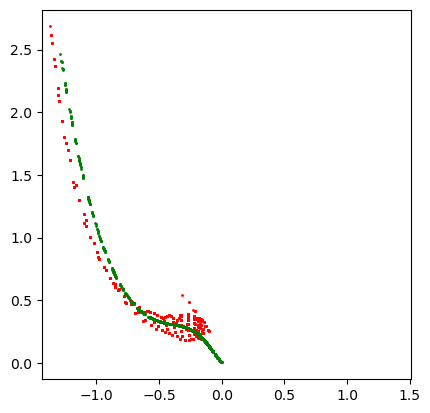

In [3]:
plt.scatter(np.real(ew_sel-1), np.imag(ew_sel-1), s=1, color='r')
plt.scatter(np.real(components), np.imag(components), s=1, color='g')
plt.axis("square")
plt.show()

Position optimization

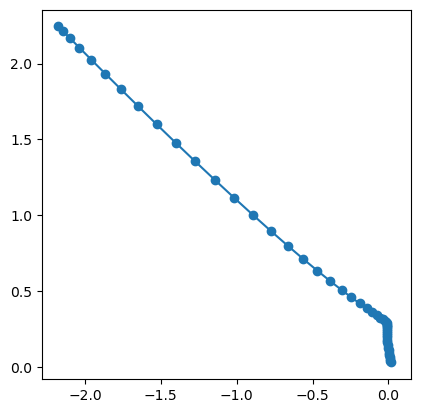

In [4]:
plt.scatter(np.real(results), np.imag(results))
plt.plot(np.real(results), np.imag(results))
plt.axis("square")
plt.show()

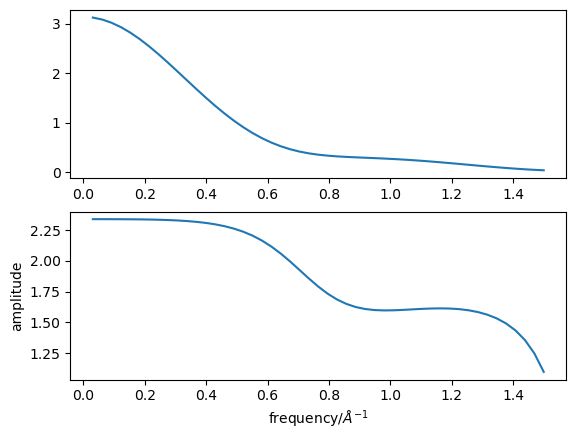

In [5]:
length = results.shape[0]
krange = np.linspace(gmin, gmax, length)
plt.subplot(2, 1, 1)
plt.plot(krange, np.abs(results))
plt.subplot(2, 1, 2)
plt.plot(krange, np.angle(results))
plt.xlabel(r"frequency$/\AA^{-1}$")
plt.ylabel("amplitude")
plt.show()

/var/folders/06/8n008hdd2ls9jb4qk47sydy00000gn/T/ipykernel_6967/1290201971.py:17: RuntimeWarning: invalid value encountered in divide
  results = np.array(results)/np.sqrt(krange)


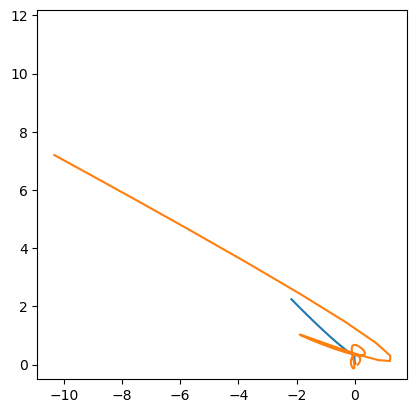

In [6]:
length = 50
results1, components1 = Bessel_transform(ew_sel-1, sampling, gmin, gmax, length, x0=sampling, y0=sampling)
results2, components2 = Bessel_transform(ew-1, sampling, gmin, gmax, length, x0=sampling, y0=sampling)
krange = np.linspace(gmin, gmax, length)
plt.plot(np.real(results1), np.imag(results1))
plt.plot(np.real(results2), np.imag(results2))
plt.axis("square")
plt.show()

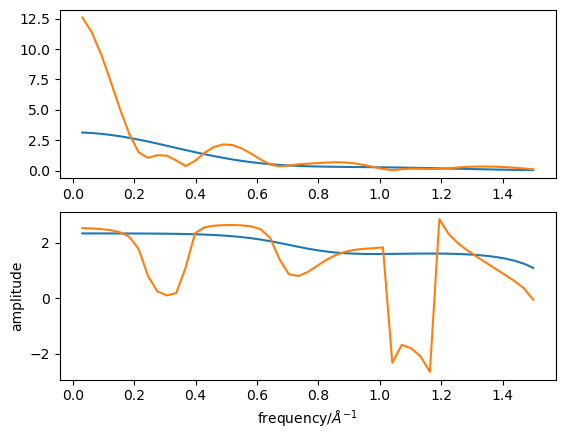

In [7]:
plt.subplot(2, 1, 1)
plt.plot(krange, np.abs(results1))
plt.plot(krange, np.abs(results2))
plt.subplot(2, 1, 2)
plt.plot(krange, np.angle(results1))
plt.plot(krange, np.angle(results2))
plt.xlabel(r"frequency$/\AA^{-1}$")
plt.ylabel("amplitude")
plt.show()

/var/folders/06/8n008hdd2ls9jb4qk47sydy00000gn/T/ipykernel_6967/1290201971.py:17: RuntimeWarning: invalid value encountered in divide
  results = np.array(results)/np.sqrt(krange)


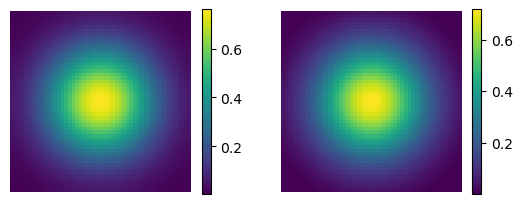

In [ ]:
width_demo = 50
x = np.linspace(-width_demo*sampling/2, width_demo*sampling/2, width_demo)
y = np.linspace(-width_demo*sampling/2, width_demo*sampling/2, width_demo)
X, Y = np.meshgrid(x, y); R2 = X**2 + Y**2
phi = np.pi/4
func_result = np.exp(-R2)*(np.exp(1j*phi)-1) + 1
func_result = select_freq_range(func_result, gmin, gmax, sampling)
results, components = Bessel_transform(func_result-1, sampling, gmin, gmax, 50, 0, 0)
plt.subplot(1, 2, 1)
plt.imshow(np.abs(func_result-1))
plt.axis("off")
plt.colorbar(shrink=0.5)
plt.subplot(1, 2, 2)
plt.imshow(np.abs(components))
plt.axis("off")
plt.colorbar(shrink=0.5)
plt.show()

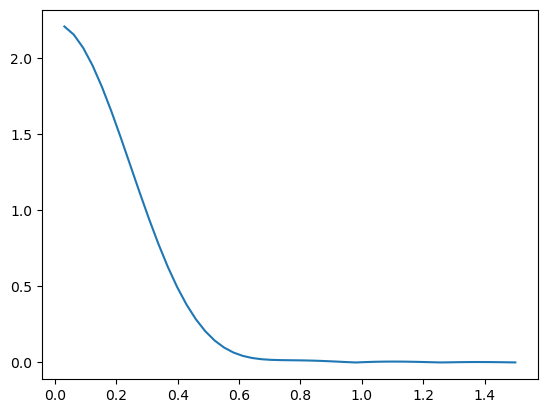

In [9]:
freq_range = np.linspace(gmin, gmax, 50)
plt.plot(freq_range, np.abs(results))
plt.show()

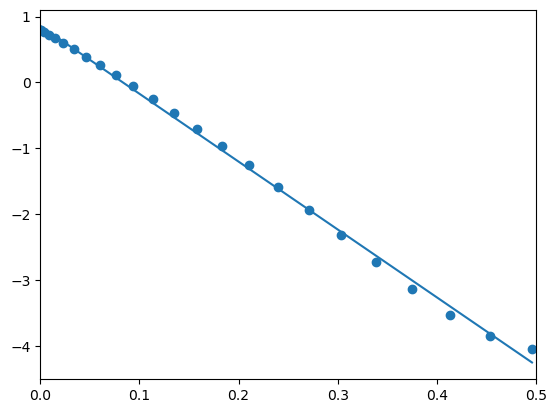

In [10]:
from sklearn.linear_model import LinearRegression
freq_range = np.linspace(gmin, gmax, 50)
freq_index = np.where(np.logical_and(freq_range**2>0, freq_range**2 < 0.5))
X = (freq_range[freq_index]**2).reshape(-1, 1)
y = np.log(np.abs(results[freq_index]))
res = LinearRegression().fit(X, y)
plt.scatter(X, y)
plt.plot(X, res.predict(X))
plt.xlim(0, 0.5)
plt.show()

/var/folders/06/8n008hdd2ls9jb4qk47sydy00000gn/T/ipykernel_6967/1290201971.py:17: RuntimeWarning: invalid value encountered in divide
  results = np.array(results)/np.sqrt(krange)


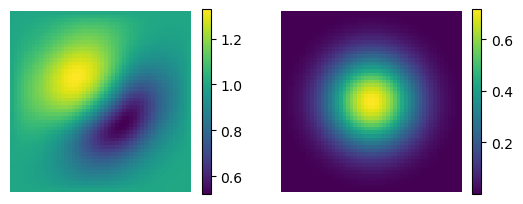

In [17]:
width_demo = 50
x = np.linspace(-width_demo*sampling/2, width_demo*sampling/2, width_demo)
y = np.linspace(-width_demo*sampling/2, width_demo*sampling/2, width_demo)
X, Y = np.meshgrid(x, y); R2 = X**2 + Y**2
phi = np.pi/4; kx = 1; ky = 1
func_result = np.exp(-R2)*np.exp(1j*(kx*X+ky*Y))*(np.exp(1j*phi)-1) + 1
func_result = select_freq_range(func_result, gmin, gmax, sampling)
results, components = Bessel_transform(func_result-1, sampling, gmin, gmax, 50, 0, 0)
plt.subplot(1, 2, 1)
plt.imshow(np.abs(func_result))
plt.axis("off")
plt.colorbar(shrink=0.5)
plt.subplot(1, 2, 2)
plt.imshow(np.abs(components))
plt.axis("off")
plt.colorbar(shrink=0.5)
plt.show()

/var/folders/06/8n008hdd2ls9jb4qk47sydy00000gn/T/ipykernel_6967/1290201971.py:17: RuntimeWarning: invalid value encountered in divide
  results = np.array(results)/np.sqrt(krange)


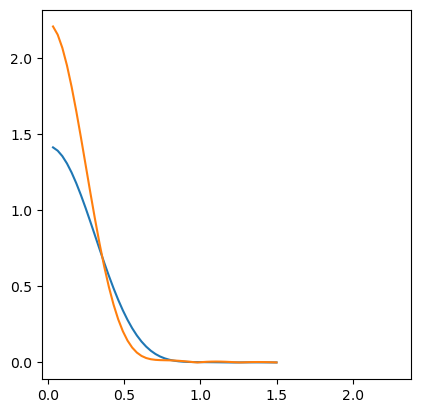

In [23]:
width_demo = 50
x = np.linspace(-width_demo*sampling/2, width_demo*sampling/2, width_demo)
y = np.linspace(-width_demo*sampling/2, width_demo*sampling/2, width_demo)
X, Y = np.meshgrid(x, y); R2 = X**2 + Y**2
phi = np.pi/4; kx = 1; ky = 1
func_result = np.exp(-R2)*np.exp(1j*(kx*X+ky*Y))*(np.exp(1j*phi)-1) + 1
func_result = select_freq_range(func_result, gmin, gmax, sampling)
results, components = Bessel_transform(func_result-1, sampling, gmin, gmax, 50, 0, 0)
#plt.scatter(np.real(results), np.imag(results), s=1)
plt.plot(freq_range, np.abs(results))
func_result = np.exp(-R2)*(np.exp(1j*phi)-1) + 1
func_result = select_freq_range(func_result, gmin, gmax, sampling)
results, components = Bessel_transform(func_result-1, sampling, gmin, gmax, 50, 0, 0)
#plt.scatter(np.real(results), np.imag(results), s=1)
plt.plot(freq_range, np.abs(results))
plt.axis("square")
plt.show()

/var/folders/06/8n008hdd2ls9jb4qk47sydy00000gn/T/ipykernel_6967/1290201971.py:17: RuntimeWarning: invalid value encountered in divide
  results = np.array(results)/np.sqrt(krange)


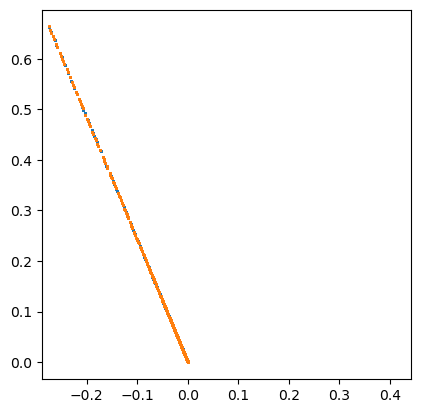

In [20]:
width_demo = 50
x = np.linspace(-width_demo*sampling/2, width_demo*sampling/2, width_demo)
y = np.linspace(-width_demo*sampling/2, width_demo*sampling/2, width_demo)
X, Y = np.meshgrid(x, y); R2 = X**2 + Y**2
phi = np.pi/4; kx = 1; ky = 1
func_result = np.exp(-R2)*np.exp(1j*(kx*X+ky*Y))*(np.exp(1j*phi)-1) + 1
func_result = select_freq_range(func_result, gmin, gmax, sampling)
results, components = Bessel_transform(func_result-1, sampling, gmin, gmax, 50, 0, 0)
plt.scatter(np.real(components), np.imag(components), s=1)
func_result = np.exp(-R2)*(np.exp(1j*phi)-1) + 1
func_result = select_freq_range(func_result, gmin, gmax, sampling)
results, components = Bessel_transform(func_result-1, sampling, gmin, gmax, 50, 0, 0)
plt.scatter(np.real(components), np.imag(components), s=1)
plt.axis("square")
plt.show()